# 016.不同尺寸的图像加法

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
img_l = cv2.imread("./dataplt/addCV.png")
img_s = cv2.imread("./dataplt/addCVG.png")

x,y = 300,50  # 叠放位置
W1, H1 = img_l.shape[1::-1]  # 大图尺寸
W2, H2 = img_s.shape[1::-1]  # 小图尺寸
if (x + W2) > W1: x = W1 - W2  # 调整图像叠放位置，避免溢出
if (y + H2) > H1: y = H1 - H2

imgCrop = img_l[y:y + H2, x:x + W2]  # 裁剪大图，与小图 imgS 的大小相同
imgAdd = cv2.add(imgCrop, img_s)  # cv2 加法，裁剪图与小图叠加
alpha, beta, gamma = 0.2, 0.8, 0.0  # 加法权值
imgAddW = cv2.addWeighted(imgCrop, alpha, img_s, beta, gamma)  # 加权加法，裁剪图与小图叠加

imgAddM = np.array(img_l)
imgAddM[y:y + H2, x:x + W2] = imgAddW  # 用叠加小图替换原图 imgL 的叠放位置

cv2.imshow("imgAdd", imgAdd)
cv2.imshow("imgAddW", imgAddW)
cv2.imshow("imgAddM", imgAddM)
cv2.waitKey(0)

-1

#### Other

dftMag max=1135630336.0, min=0.6020045280456543
dftPhi max=179.99996948242188, min=-179.99998474121094
dftAmpLog max=20.850454330444336, min=0.47125568985939026


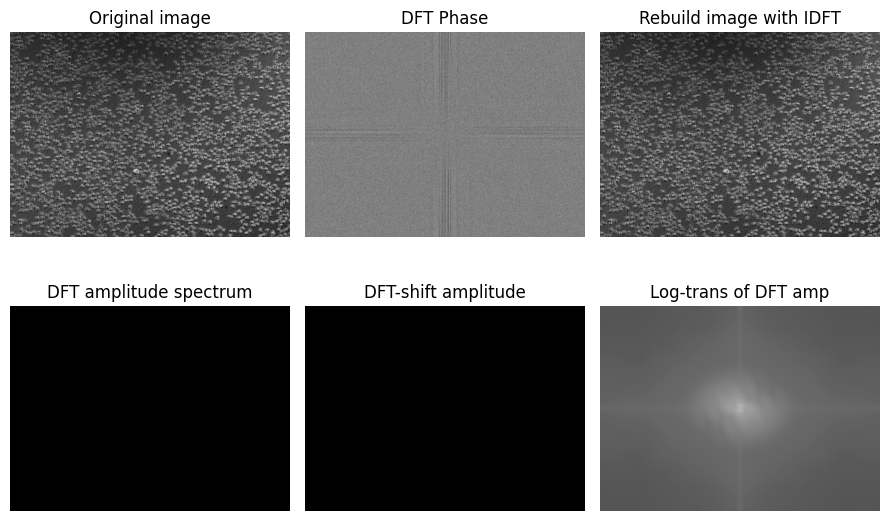

In [3]:
# 8.11：OpenCV 实现二维图像的离散傅里叶变换
imgGray = cv2.imread("./dataplt/addCV.png", flags=0)  # flags=0 读取为灰度图像

# cv2.dft 实现图像的傅里叶变换
imgFloat32 = np.float32(imgGray)  # 将图像转换成 float32
dft = cv2.dft(imgFloat32, flags=cv2.DFT_COMPLEX_OUTPUT)  # 傅里叶变换
dftShift = np.fft.fftshift(dft)  # 将低频分量移动到频域图像的中心

# 幅度谱
# ampSpe = np.sqrt(np.power(dft[:,:,0], 2) + np.power(dftShift[:,:,1], 2))
dftAmp = cv2.magnitude(dft[:,:,0], dft[:,:,1])  # 幅度谱，未中心化
dftShiftAmp = cv2.magnitude(dftShift[:,:,0], dftShift[:,:,1])  # 幅度谱，中心化
dftAmpLog = np.log(1 + dftShiftAmp)  # 幅度谱对数变换，以便于显示
# 相位谱
phase = np.arctan2(dftShift[:,:,1], dftShift[:,:,0])  # 计算相位角(弧度制)
dftPhi = phase / np.pi*180  # 将相位角转换为 [-180, 180]

print("dftMag max={}, min={}".format(dftAmp.max(), dftAmp.min()))
print("dftPhi max={}, min={}".format(dftPhi.max(), dftPhi.min()))
print("dftAmpLog max={}, min={}".format(dftAmpLog.max(), dftAmpLog.min()))

# cv2.idft 实现图像的逆傅里叶变换
invShift = np.fft.ifftshift(dftShift)  # 将低频逆转换回图像四角
imgIdft = cv2.idft(invShift)  # 逆傅里叶变换
imgRebuild = cv2.magnitude(imgIdft[:,:,0], imgIdft[:,:,1])  # 重建图像

plt.figure(figsize=(9, 6))
plt.subplot(231), plt.title("Original image"), plt.axis('off')
plt.imshow(imgGray, cmap='gray')
plt.subplot(232), plt.title("DFT Phase"), plt.axis('off')
plt.imshow(dftPhi, cmap='gray')
plt.subplot(233), plt.title("Rebuild image with IDFT"), plt.axis('off')
plt.imshow(imgRebuild, cmap='gray')
plt.subplot(234), plt.title("DFT amplitude spectrum"), plt.axis('off')
plt.imshow(dftAmp, cmap='gray')
plt.subplot(235), plt.title("DFT-shift amplitude"), plt.axis('off')
plt.imshow(dftShiftAmp, cmap='gray')
plt.subplot(236), plt.title("Log-trans of DFT amp"), plt.axis('off')
plt.imshow(dftAmpLog, cmap='gray')
plt.tight_layout()
plt.show()

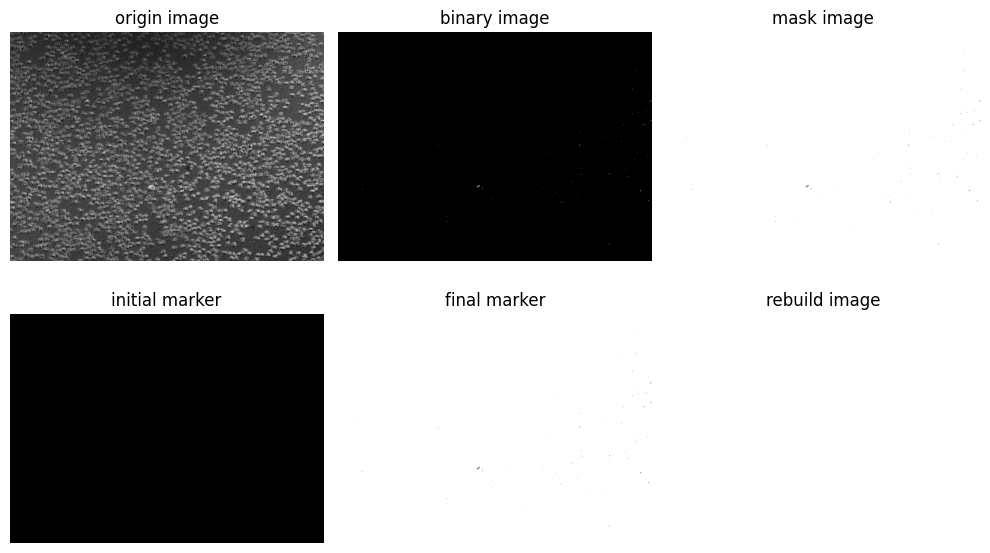

In [4]:
# 10.24: 基于形态学重建的细胞计数
imgGray = cv2.imread("./dataplt/addCV.png", flags=0)  # flags=0 灰度图像
ret, imgBin = cv2.threshold(imgGray, 205, 255, cv2.THRESH_BINARY)  # 二值化处理 (黑色0/白色1)
imgMask = cv2.bitwise_not(imgBin)  # 二值图像的补集

# 构造标记图像
marker = np.zeros_like(imgBin, dtype=np.uint8)
marker[0, :] = imgBin[0, :]
marker[-1, :] = imgBin[-1, :]
marker[:, 0] = imgBin[:, 0]
marker[:, -1] = imgBin[:, -1]
markerIni = marker.copy()  # 标记图像: 边框 f(x,y)=I(x,y)，其它为 0

# 形态学重建
element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
while True:
    marker_pre = marker  # 保存 F(n-1)
    dilation = cv2.dilate(marker, kernel=element)  # 膨胀重建
    marker = cv2.bitwise_and(dilation, imgMask)  # 原图像作为模板用来约束重建，按位与，有 0 得 0
    if (marker_pre == marker).all():  # F(n)=F(n-1)?，判断是否达到稳定收敛状态
        break
# imgRebuild = imgBin + marker  # 按位或，有 1 得 1
imgRebuild = cv2.bitwise_or(imgBin, marker)  # 按位或，有 1 得 1

# 显示
plt.figure(figsize=(10, 6))
plt.subplot(231), plt.imshow(imgGray, cmap='gray'), plt.title("origin image"), plt.axis("off")
plt.subplot(232), plt.imshow(imgBin, cmap='gray'), plt.title("binary image"), plt.axis("off")
plt.subplot(233), plt.imshow(imgMask, cmap='gray'), plt.title("mask image"), plt.axis("off")
plt.subplot(234), plt.imshow(markerIni, cmap='gray'), plt.title("initial marker"), plt.axis("off")
plt.subplot(235), plt.imshow(marker, cmap='gray'), plt.title("final marker"), plt.axis("off")
plt.subplot(236), plt.imshow(imgRebuild, cmap='gray'), plt.title("rebuild image"), plt.axis("off")
plt.tight_layout()
plt.show()
